In [2]:
from conex import *
import torch
from pymonntorch import *

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [14]:
prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 10,
        R = 1,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    InherentNoise(scale = 10, offset = 15),
    Fire(),
    NeuronAxon(),
])

{220: SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,),
 240: SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,),
 260: LIF(R=1,tau=10,threshold=-13,v_reset=-70,v_rest=-65,init_v=None,init_s=None,),
 280: InherentNoise(mode=rand,scale=10,offset=15,),
 340: Fire(),
 380: NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=None,)}

In [213]:
net = Network(behavior = prioritize_behaviors([
    TimeResolution(),
]))

ng1 = NeuronGroup(size = 10, net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 7,
        R = 10,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    Fire(),
    SpikeTrace(tau_s = 15),
    NeuronAxon(),
]) | ({
    341 : PoissionGenerator(offset = [0, 60], T = [40, 40], lamda = [20, 20]),
    800 : Recorder(['v', "I", 'trace']),
    801 : EventRecorder(['spikes'])
}))

ng2 = NeuronGroup(size = 10, net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 7,
        R = 10,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    Fire(),
    SpikeTrace(tau_s = 15),
    NeuronAxon(),
]) | ({
    800 : Recorder(['v', "I", "trace"]),
    801 : EventRecorder(['spikes'])
}))

sg = SynapseGroup(net = net, src = ng1, dst = ng2, tag = "Proximal,exi", behavior = prioritize_behaviors([
    SynapseInit(),
    WeightInitializer(mode = "normal(10, 5)"),
    SimpleDendriticInput(),
    SimpleSTDP(
        w_min = 0,
        w_max = 25,
        a_plus = 1.2,
        a_minus = 1,
    ),
]) | ({
    800 : Recorder(["I"]),
}))

In [214]:
net.initialize()
net.simulate_iterations(100)

Network['Network'](Neurons: tensor(20)|2 groups, Synapses: tensor(100)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](10){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=10,tau=7,threshold=-13,v_reset=-70,v_rest=-65,init_v=None,init_s=None,)340:Fire()341:PoissionGenerator(offset=[0, 60],T=[40, 40],lamda=[20, 20],)360:SpikeTrace(tau_s=15,)380:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=None,)800:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['v', 'I', 'trace'],)801:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spikes'],)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](10){220:SimpleDendriteStructure(Prox

C:\Users\Asus\AppData\Local\Temp\ipykernel_17384\3868640290.py:21: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  self.poisson = (np.exp(-self.lamda[pat]) * (self.lamda[pat] ** (ng.network.iteration - self.offset[pat]))) / (np.math.factorial(ng.network.iteration - self.offset[pat])) / ((np.exp(-self.lamda[pat]) * (self.lamda[pat] ** self.lamda[pat])) / (np.math.factorial(self.lamda[pat]))*2)


100xBatch: 1/1 (100%) 497.768ms


497.7679252624512

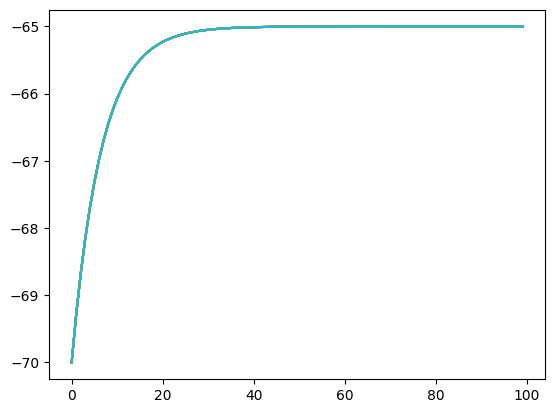

In [215]:
plt.plot(ng1['v', 0])
plt.show()

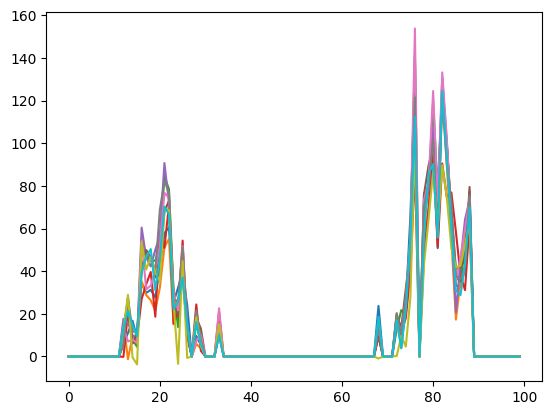

In [216]:
plt.plot(ng2['I', 0])
plt.show()

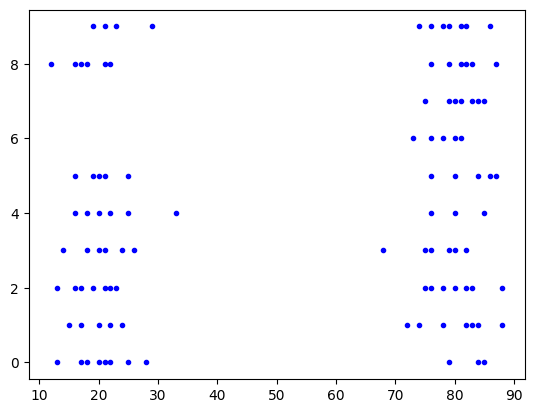

In [217]:
plt.plot(ng1['spikes.t', 0], ng1['spikes.i', 0], '.', color = "blue")

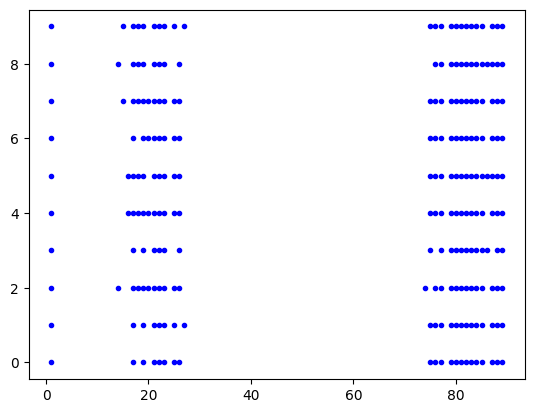

In [218]:
plt.plot(ng2['spikes.t', 0], ng2['spikes.i', 0], '.', color = "blue")

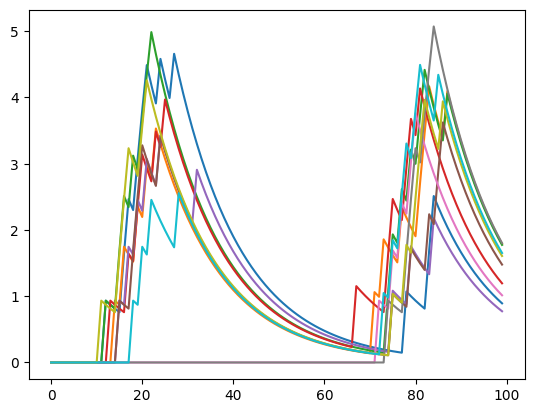

In [219]:
plt.plot(ng1['trace', 0])
plt.show()

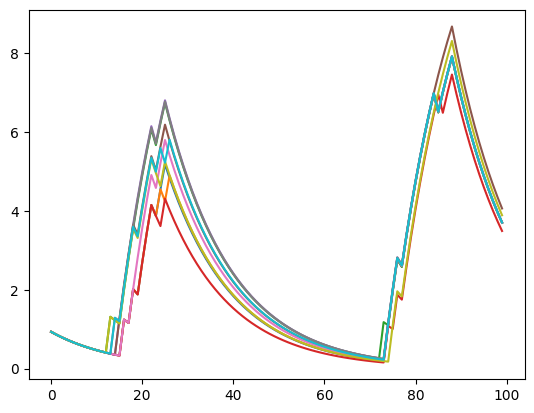

In [220]:
plt.plot(ng2['trace', 0])
plt.show()

In [25]:
class PoissionGenerator(Behavior) :

    def initialize(self, ng) : 
        self.offset = ng.network.iteration
        self.T = self.parameter("T", 50)
        self.lamda = self.parameter("lamda", 20)
        self.target = self.parameter("target", required = True)
        self.poisson = 0

    def forward(self, ng) : 
        pat = self.pattern(ng)
        if(pat == -1) : 
            ng.spikes[self.target] = torch.rand(len(self.target)) < 0
        else :
            self.poisson = (np.exp(-self.lamda) * (self.lamda ** (ng.network.iteration - self.offset))) / (np.math.factorial(ng.network.iteration - self.offset)) / ((np.exp(-self.lamda) * (self.lamda ** self.lamda)) / (np.math.factorial(self.lamda))*2)
            ng.spikes[self.target] = torch.rand(len(self.target)) <= self.poisson/1.5

    def pattern(self, ng) : 
        if(ng.network.iteration - self.offset > self.T) : 
            return -1   
        return 1

# Simple STDP

In [56]:
net = Network(behavior = prioritize_behaviors([
    TimeResolution(),
]))

ng1 = NeuronGroup(size = 10, net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 7,
        R = 10,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    Fire(),
    SpikeTrace(tau_s = 15),
    NeuronAxon(),
]) | ({
    # 341 : PoissionGenerator(T = 50, lamda = 20, target = [0, 1, 2, 3, 4]),
    800 : Recorder(['v', "I", 'trace']),
    801 : EventRecorder(['spikes'])
}))

ng2 = NeuronGroup(size = 2, net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 10,
        R = 8,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    # KWTA(k = 1),
    Fire(),
    SpikeTrace(tau_s = 15),
    NeuronAxon(),
]) | ({
    800 : Recorder(['v', "I", "trace"]),
    801 : EventRecorder(['spikes'])
}))

sg = SynapseGroup(net = net, src = ng1, dst = ng2, tag = "Proximal,exi", behavior = prioritize_behaviors([
    SynapseInit(),
    WeightInitializer(mode = "normal(6, 4)"),
    SimpleDendriticInput(),
    SimpleSTDP(
        w_min = 0,
        w_max = 15,
        a_plus = 1.2,
        a_minus = 1,
    ),
    WeightClip(w_min = 0, w_max = 15)
    # WeightNormalization(norm = 50)
]) | ({
    800 : Recorder(["I", "weights"]),
}))

# Run Network

In [57]:
net.initialize()

for i in range(20) : 
    if(i % 2 == 0) : 
        ng1.add_behavior(341, PoissionGenerator(T = 50, lamda = 20, target = [0, 1, 2, 3, 4]))
    else :
        ng1.add_behavior(341, PoissionGenerator(T = 50, lamda = 20, target = [5, 6, 7, 8, 9]))

    net.simulate_iterations(100)
    ng1.remove_behavior(341)

# Resting phase
net.simulate_iterations(200)

# test-phase
ng2.remove_behavior(400) # Remove STDP
for i in range(4) : 
    if i < 2 : 
        ng1.add_behavior(341, PoissionGenerator(T = 50, lamda = 20, target = [0, 1, 2, 3, 4]))
    else :
        ng1.add_behavior(341, PoissionGenerator(T = 50, lamda = 20, target = [5, 6, 7, 8, 9]))

    net.simulate_iterations(100)
    ng1.remove_behavior(341)

Network['Network'](Neurons: tensor(12)|2 groups, Synapses: tensor(20)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](10){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=10,tau=7,threshold=-13,v_reset=-70,v_rest=-65,init_v=None,init_s=None,)340:Fire()360:SpikeTrace(tau_s=15,)380:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=None,)800:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['v', 'I', 'trace'],)801:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spikes'],)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](2){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal

C:\Users\Asus\AppData\Local\Temp\ipykernel_20472\1493305673.py:15: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  self.poisson = (np.exp(-self.lamda) * (self.lamda ** (ng.network.iteration - self.offset))) / (np.math.factorial(ng.network.iteration - self.offset)) / ((np.exp(-self.lamda) * (self.lamda ** self.lamda)) / (np.math.factorial(self.lamda))*2)


100xBatch: 1/1 (100%) 169.541ms
100xBatch: 1/1 (100%) 155.435ms
100xBatch: 1/1 (100%) 191.651ms
100xBatch: 1/1 (100%) 173.150ms
100xBatch: 1/1 (100%) 178.635ms
100xBatch: 1/1 (100%) 182.174ms
100xBatch: 1/1 (100%) 171.729ms
100xBatch: 1/1 (100%) 181.556ms
100xBatch: 1/1 (100%) 187.307ms
100xBatch: 1/1 (100%) 189.102ms
100xBatch: 1/1 (100%) 191.951ms
100xBatch: 1/1 (100%) 183.993ms
100xBatch: 1/1 (100%) 166.965ms
100xBatch: 1/1 (100%) 161.119ms
100xBatch: 1/1 (100%) 176.529ms
100xBatch: 1/1 (100%) 257.311ms
100xBatch: 1/1 (100%) 268.275ms
100xBatch: 1/1 (100%) 317.152ms
100xBatch: 1/1 (100%) 335.486ms
200xBatch: 1/1 (100%) 598.365ms
100xBatch: 1/1 (100%) 374.146ms
100xBatch: 1/1 (100%) 353.404ms
100xBatch: 1/1 (100%) 330.120ms
100xBatch: 1/1 (100%) 292.921ms


# Results

In [875]:
def convergence_metric(sg, K, W_min = 0, W_max = 15) : 
    conv_rate = 0
    for i in range(K) : 
        conv_rate += torch.sum((W_max - sg['weights', 0][:,:,i])*(sg['weights', 0][:,:,i] - W_min), axis = 1) / 10
    
    conv_rate /= K
    return conv_rate
        

C:\Users\Asus\AppData\Local\Temp\ipykernel_20472\2823110459.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(ng2['spikes.t', 0], ng2['spikes.i', 0], '.', color = "blue", marker = "|", markersize = 20, markeredgewidth=1.4)


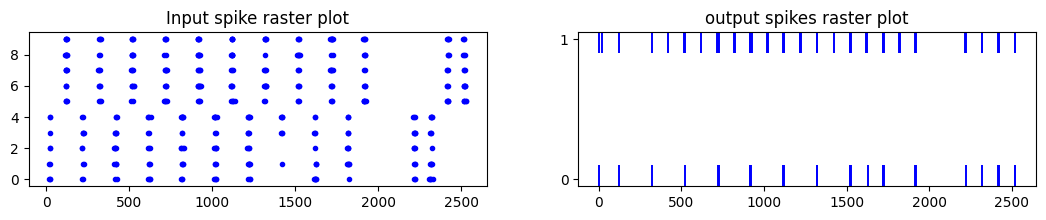

In [58]:
plt.figure(figsize = (13, 2))

plt.subplot(1, 2, 1)
plt.plot(ng1['spikes.t', 0][10:], ng1['spikes.i', 0][10:], '.', color = "blue")
plt.title("Input spike raster plot")

plt.subplot(1, 2, 2)
plt.plot(ng2['spikes.t', 0], ng2['spikes.i', 0], '.', color = "blue", marker = "|", markersize = 20, markeredgewidth=1.4)
plt.title("output spikes raster plot")
plt.yticks([0, 1])

plt.show()

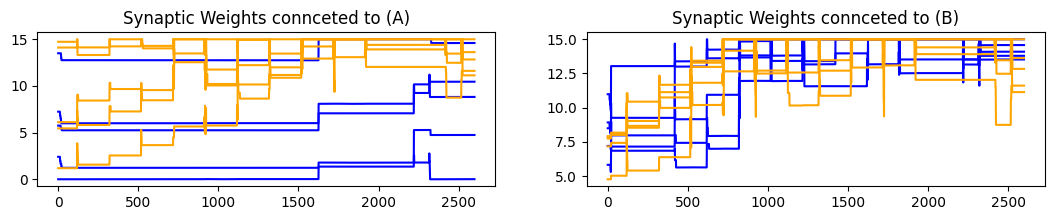

In [59]:
plt.figure(figsize = (13, 2))

plt.subplot(1, 2, 1)
A = sg['weights', 0][:,:,0]
plt.plot(A[:,:5], color = "blue")
plt.plot(A[:,5:], color = "orange")
plt.title("Synaptic Weights connceted to (A)")

plt.subplot(1, 2, 2)
A = sg['weights', 0][:,:,1]
plt.plot(A[:,:5], color = "blue")
plt.plot(A[:,5:], color = "orange")
plt.title("Synaptic Weights connceted to (B)")


plt.show()

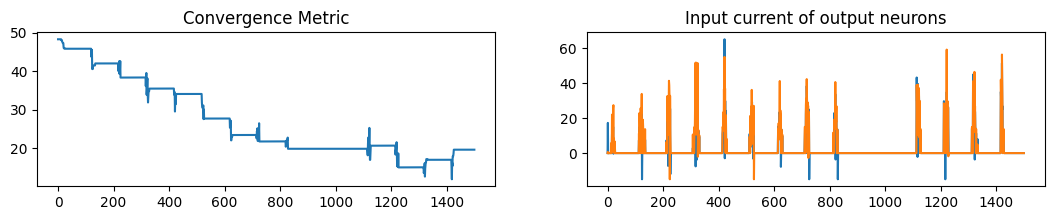

In [180]:
plt.figure(figsize = (13, 2))

plt.subplot(1, 2, 1)
plt.plot(convergence_metric(sg, 2))
plt.title("Convergence Metric")

plt.subplot(1, 2, 2)
plt.plot(ng2['I', 0])
plt.title("Input current of output neurons")

plt.show()

In [491]:
class WeightDecay(Behavior) :

    def initialize(self, sg) : 
        self.decay_rate = self.parameter("decay_rate", 0.99)

    def forward(self, sg) : 
        sg.weights *= self.decay_rate

In [996]:
net = Network(behavior = prioritize_behaviors([
    TimeResolution(),
]))

ng1 = NeuronGroup(size = 9, net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 7,
        R = 10,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    Fire(),
    SpikeTrace(tau_s = 15),
    NeuronAxon(),
]) | ({
    # 341 : PoissionGenerator(T = 50, lamda = 20, target = [0, 1, 2, 3, 4]),
    800 : Recorder(['v', "I", 'trace']),
    801 : EventRecorder(['spikes'])
}))

ng2 = NeuronGroup(size = 2, net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 10,
        R = 8,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    KWTA(k = 1),
    Fire(),
    SpikeTrace(tau_s = 15),
    NeuronAxon(),
]) | ({
    800 : Recorder(['v', "I", "trace"]),
    801 : EventRecorder(['spikes'])
}))

sg = SynapseGroup(net = net, src = ng1, dst = ng2, tag = "Proximal,exi", behavior = prioritize_behaviors([
    SynapseInit(),
    WeightInitializer(mode = "normal(5, 3)"),
    SimpleDendriticInput(),
    SimpleSTDP(
        w_min = 0,
        w_max = 15,
        a_plus = 0.5,
        a_minus = 0.3,
    ),
    WeightClip(w_min = 0, w_max = 15),
    WeightNormalization(norm = 70)
]) | ({
    # 439 : WeightDecay(decay_rate = 0.9999),
    800 : Recorder(["I", "weights"]),
}))

weights = torch.Tensor([1, 0, 1])
weight_shape = (1, 1, 1, 1, 3)
weights = weights.view(weight_shape)


sg_lateral = SynapseGroup(net = net, src = ng2, dst = ng2, tag = "Proximal, inh", behavior= prioritize_behaviors([
    SynapseInit(),
    WeightInitializer(weights = weights, weight_shape = weight_shape),
    LateralDendriticInput(inhibitory = True, current_coef = 8)
])| ({
    800 : Recorder(["I"]),
}))

In [997]:
net.initialize()

MAX_EPOCH = 10

PATTERN_1 = [0, 1, 2, 3, 4, 5]
PATTERN_2 = [3, 4, 5, 6, 7, 8]

i = 0
while(True) :
    if(i % 10 < 5) : 
        ng1.add_behavior(341, PoissionGenerator(T = 50, lamda = 20, target = PATTERN_1))
    else :
        ng1.add_behavior(341, PoissionGenerator(T = 50, lamda = 20, target = PATTERN_2))


    net.simulate_iterations(100)
    ng1.remove_behavior(341)
    net.simulate_iterations(50)

    conv_rate = convergence_metric(sg, 2)[-1]    
    if(conv_rate < 10 or i/2 > MAX_EPOCH) :
        break 

    i += 1

# Resting phase
net.simulate_iterations(200)

# test-phase
ng2.remove_behavior(400) # Remove STDP
for i in range(4) : 
    if i < 2 : 
        ng1.add_behavior(341, PoissionGenerator(T = 50, lamda = 20, target = PATTERN_1))
    else :
        ng1.add_behavior(341, PoissionGenerator(T = 50, lamda = 20, target = PATTERN_2))

    net.simulate_iterations(100)
    ng1.remove_behavior(341)

Network['Network'](Neurons: tensor(11)|2 groups, Synapses: tensor(22)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](9){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=10,tau=7,threshold=-13,v_reset=-70,v_rest=-65,init_v=None,init_s=None,)340:Fire()360:SpikeTrace(tau_s=15,)380:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=None,)800:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['v', 'I', 'trace'],)801:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spikes'],)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](2){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_

C:\Users\Asus\AppData\Local\Temp\ipykernel_20472\1493305673.py:15: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  self.poisson = (np.exp(-self.lamda) * (self.lamda ** (ng.network.iteration - self.offset))) / (np.math.factorial(ng.network.iteration - self.offset)) / ((np.exp(-self.lamda) * (self.lamda ** self.lamda)) / (np.math.factorial(self.lamda))*2)


100xBatch: 1/1 (100%) 326.128ms
50xBatch: 1/1 (100%) 171.542ms
100xBatch: 1/1 (100%) 284.794ms
50xBatch: 1/1 (100%) 139.627ms
100xBatch: 1/1 (100%) 347.472ms
50xBatch: 1/1 (100%) 152.591ms
100xBatch: 1/1 (100%) 337.878ms
50xBatch: 1/1 (100%) 110.601ms
100xBatch: 1/1 (100%) 298.709ms
50xBatch: 1/1 (100%) 160.569ms
100xBatch: 1/1 (100%) 326.780ms
50xBatch: 1/1 (100%) 125.242ms
100xBatch: 1/1 (100%) 267.154ms
50xBatch: 1/1 (100%) 163.969ms
100xBatch: 1/1 (100%) 552.210ms
50xBatch: 1/1 (100%) 156.145ms
100xBatch: 1/1 (100%) 310.967ms
50xBatch: 1/1 (100%) 174.536ms
100xBatch: 1/1 (100%) 327.676ms
50xBatch: 1/1 (100%) 139.095ms
100xBatch: 1/1 (100%) 281.787ms
50xBatch: 1/1 (100%) 154.151ms
100xBatch: 1/1 (100%) 308.013ms
50xBatch: 1/1 (100%) 165.777ms
100xBatch: 1/1 (100%) 323.136ms
50xBatch: 1/1 (100%) 130.652ms
100xBatch: 1/1 (100%) 324.704ms
50xBatch: 1/1 (100%) 164.560ms
100xBatch: 1/1 (100%) 324.778ms
50xBatch: 1/1 (100%) 145.610ms
100xBatch: 1/1 (100%) 284.239ms
50xBatch: 1/1 (100%) 15

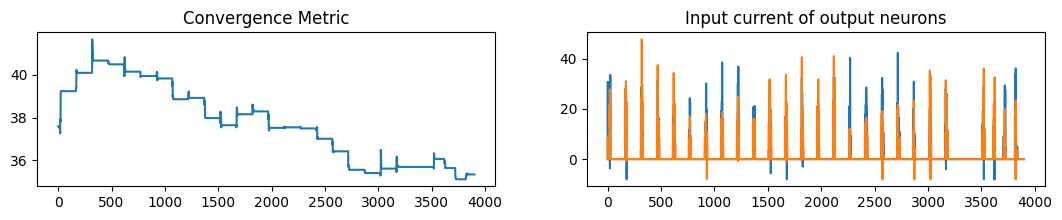

In [998]:
plt.figure(figsize = (13, 2))

plt.subplot(1, 2, 1)
plt.plot(convergence_metric(sg, 2, W_max=15))
plt.title("Convergence Metric")

plt.subplot(1, 2, 2)
plt.plot(ng2['I', 0])
plt.title("Input current of output neurons")

plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_20472\1408685001.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(ng2['spikes.t', 0], ng2['spikes.i', 0], '.', color = "blue", marker = "|", markersize = 20, markeredgewidth=1.4)


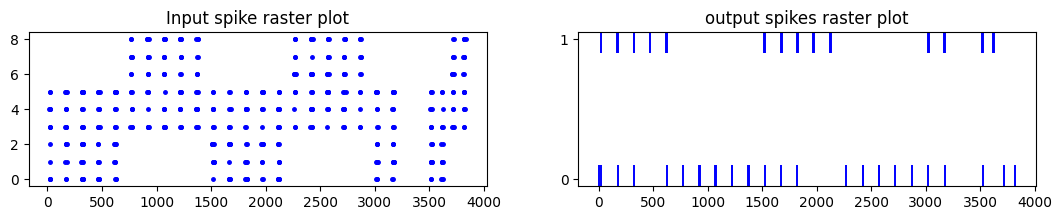

In [999]:
plt.figure(figsize = (13, 2))

plt.subplot(1, 2, 1)
plt.plot(ng1['spikes.t', 0][9:], ng1['spikes.i', 0][9:], '.', color = "blue", markersize = 5)
plt.title("Input spike raster plot")

plt.subplot(1, 2, 2)
plt.plot(ng2['spikes.t', 0], ng2['spikes.i', 0], '.', color = "blue", marker = "|", markersize = 20, markeredgewidth=1.4)
plt.title("output spikes raster plot")
plt.yticks([0, 1])

plt.show()

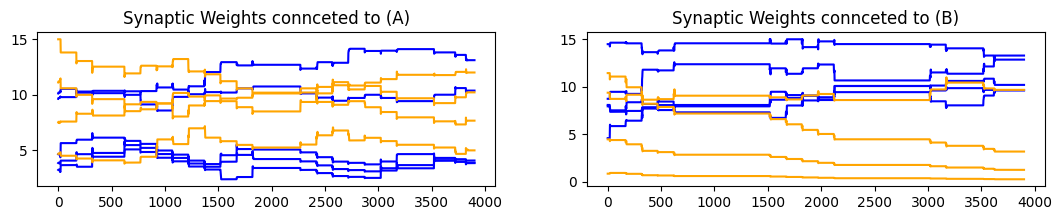

In [1000]:
plt.figure(figsize = (13, 2))

plt.subplot(1, 2, 1)
A = sg['weights', 0][:,:,0]
plt.plot(A[:,:5], color = "blue")
plt.plot(A[:,5:], color = "orange")
plt.title("Synaptic Weights connceted to (A)")

plt.subplot(1, 2, 2)
A = sg['weights', 0][:,:,1]
plt.plot(A[:,:5], color = "blue")
plt.plot(A[:,5:], color = "orange")
plt.title("Synaptic Weights connceted to (B)")


plt.show()